## Überwachtes Lernen - Lineare Regression

Nun ein Beispiel, damit die Sprache und der Ablauf beim Maschinellen Lernen betrachtet wird.
Das Beispiel arbeitet mit einfachen Daten und einem einfachen, bekannten Algorithmus.

Als generelle Werkzeuge werden **NumPy** und **Mathplotlib** verwendet, die gleich am Anfnag import werden. 
Weiteres Werkzeug ist **sklearn** oder **scikit-learn**, eine freie Software-Bibliothek zum maschinellen Lernen für die Programmiersprache Python.
Die benötigten Komponenten werden jedoch erst dann importiert, wenn sie benötigt werden.

In [1]:
# --- imports
import numpy as np
import matplotlib.pyplot as plt

### 1 Daten
Ausgangspunkt sind Daten, die der Gleichung $y = m * x + b + \mathcal{N}(0,u)$ genügen.
Hierbei ist $m$ die Steigung (*slope*) der Geraden, $b$ der $y$-Achsenabschnitt (*intercept*).
Darüber hinaus ist $\mathcal{N}(0,u)$ eine normalverteilte Unsicherheit um den Erwartungswert $0$ mit der Standardabweichung $u$ (*uncertainty*).

In der Regel sind nur Daten, jedoch keine Formel für den Zusammenhang, bekannt. Damit jedoch die verschiedenen Schritte mit den 
orignalen Ausgangsdaten abgeglichen werden können, ist die Bildung der Daten hier gleich am Anfang offengelegt.

Die Daten sind hier so einfach gewählt, damit die Daten auch gut geplotted werden können.
Dies hat jedoch den Nachteil, dass die Daten $X$ nur ein Vektor der Länge $N$ ist. 
Für manche Berechnungen in *sklearn* wird jedoch ein 2-dimensionales Array benötigt,
hier also ein $N \times 1$-Matrix. Daher werden später die Trainings- und Testdaten entsprechend angepasst ('reshape*).


Anbei zwei kleine Hilfsroutinen, die später verwendet werden
- `linear_model` um eine Gerade $y = mx + b$ zu plotten
- `mean_square_error`, um die mittlere quadratische Abweichung zwischen zweier Vektoren zu berechnen. 
  Es ist die Distanz zwischen den beiden Vektoren mit der $L_2$-Norm, dividiert durch die Dimension

In [2]:
# --- define the linear model
def linear_model (x :np.ndarray, m :float, b :float) -> np.ndarray :
    """
    calculate datapoints on a line y = m * x + b 
    :input
      x : input to function [shape: arbitrary]
      m : slope
      b : intercept
    :return m * x + b [shape: same as x]
    """
    return m * x + b

# --- define the calculation of the mean squared error
def mean_square_error (x1 :np.ndarray, x2 :np.ndarray) -> float:
    """ 
    calculate the mean square error (mse) of two vectors 
    it's the distance between the two vector with the L2-metric,
    divided by the dimension of the vectors
    input:
      x1 : first vector [shape arbitrary]
      x2 : second vector [shape: same as x]
    return: mse 
    """
    n = x1.size
    return np.sum ((x1 - x2) **2) / n

Es werden jetzt die Lerndaten generiert. Es sind Daten, die der Gleichung
$$ y = x \cdot m + b + \mathcal{N}(0, u) $$
genügen. Hierbei seien $m$ die Steigung (*slope*) der Geraden, $b$ der Achsenabschnitt (*intercept*). 
Es wird angenommen, dass die Störung / Unsicherheit (*uncertainty*) der Daten eine normalverteilte Zufallsgröße mit dem Erwartungswert $\mu = 0.0$
und der Standardabweichung $\sigma = u$ ist.

In [3]:
# --- generate learning set
# --- define parameters of the data
slope = 1.0          
intercept = 2.0      
uncertainty = 2.0    
n_points = 20        
x_min = 0.0          
x_max = 10.0         

# --- generate data points
np.random.seed (20240812)
x_data = np.random.uniform (x_min, x_max, n_points)
y_data = slope * x_data + intercept + np.random.normal (0.0, uncertainty, n_points)

Es erfolgt nun die Aufteilung in Trainingsmenge und Testmenge.
Der Parameter `test_size` bestimmt dabei den Umfang der Testdaten. Bei einem Wert kleiner als $1.0$ ist ein ein relativer Anteil.
Bei einer ganzen Zahl größer $1$ ist es eine feste Anzahl.

Anschließend werden die Daten zur Veranschaulichung geplottet.
Neben den Datenpunkten (farbig getrennt zwischen Trainingsdaten udn Testdaten)
wird auch die originäre Gerade eingezeichnet, auf deren Basis die Punkte berechnet wurden.
Im Regelfall kennt man diese Gerade nicht, sondern nur die Datenpunkte.
Ziel ist es die Parameter der Geraden zu bestimmen.
Hierbei wird angenommen, dass die zu Grunde liegende Funktion eine Gerade ist.

Der Split der Daten erfolgt nach den Zufallsprinzip. DIes wird mit der Routine `train_test_split` vom Paket sklearn durchgeführt.

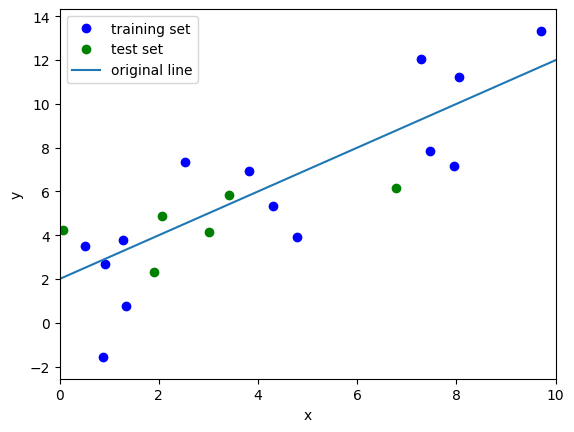

In [4]:
from sklearn.model_selection import train_test_split

# --- splitt in training- / test-set
test_size = 0.3   # 30% 
X_train, X_test, y_train, y_test = train_test_split (x_data, y_data, test_size = test_size)

# --- plot the generated data points
plt.plot (X_train, y_train, 'bo', label = "training set")
plt.plot (X_test, y_test, 'go', label = "test set")

x_line = np.linspace (x_min, x_max, 100)
plt.plot (x_line, linear_model (x_line, slope, intercept), label = "original line")

plt.xlim (x_min, x_max)
plt.xlabel ("x")
y_min = np.min (y_data) - 1.0 
y_max = np.max (y_data) + 1.0 
plt.ylim (y_min, y_max)
plt.ylabel ("y")
plt.legend ()
plt.show ()

### 2 Der Algorithmus
Da die Konstruktion der Daten bekannt ist - die Datenbasieren auf einer Geraden -, 
wird als ML Algorithmus die **Lineare Regression** (LR, *linear regression*) gewählt.

Die lineare Regression ist in der Regressionsanalyse die Bestimmung einer Geraden nach dem der Kleinst-Quadrat-Prinzip 
(siehe [Erd2020], Abschnitt 7.2). 
Die Lineare Regression wird sowohl per Hand berechnet als auch mit Hilfe von *sklearn*,
da das Verfahren in *sklearn* implementiert ist!

In [5]:
from sklearn.linear_model import LinearRegression

# --- define model
lr_model = LinearRegression ()

Per Hand ist die Implementierung der linearen Regression auch nicht schwierig.
Dies wird in der nächsten Zelle durchgeführt und dann mit den Werten von *sklearn* verglichen.
Als Basisdaten wird der gesamte Datenumfang herangezogen.
Somit wird noch kein Training durchgeführt.

Beim Vergleich wird auch die mittlere quadratische Abweichung zwischen den mit der Regressionsgerade berechneten Werten $\hat{y}$
und den tatsächlichen Werten $y$ berechnet.

In [6]:
# --- define the Lineare Regression-method
def LinReg (x : np.ndarray, y : np.ndarray):
    """
    calculate the line according the linear regression method 
    and the coefficient of correlation 
    input:
      x: x-values of the datapoints
      y: y-values of the datapoints
    return:
      m: slope of the line
      b: intercept of the line
      r2: squared coefficient of correlation
    """
    n = x.size
    sum_x = np.sum (x)
    sum_y = np.sum (y)
    sum_x2 = np.sum (x * x)
    sum_xy = np.sum (x * y)
    sum_y2 = np.sum (y * y)
    m = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x **2)
    b = (sum_x2 * sum_y - sum_x * sum_xy) / (n * sum_x2 - sum_x **2)
    r = (n * sum_xy - sum_x * sum_y) / (np.sqrt (n *sum_x2 - sum_x **2) * np.sqrt (n * sum_y2 - sum_y **2))
    r2 = r * r
    return m, b, r2

slope_LinReg, intercept_LinReg, corr_coeff_LinReg = LinReg (x_data, y_data)
mse_LinReg = mean_square_error (y_data, linear_model (x_data, slope_LinReg, intercept_LinReg))

# --- calculation with sklearn
x_reshape = x_data.reshape (-1,1)
# You should call .reshape() on x because this array must be two-dimensional, or more precisely, 
# it must have one column and as many rows as necessary. 
# That’s exactly what the argument (-1, 1) of .reshape() specifies.
# https://realpython.com/linear-regression-in-python/

# --- fit the model
lr_model.fit (x_reshape, y_data)
corr_coeff_sklearn = lr_model.score (x_reshape, y_data) # R^2 !!!
intercept_sklearn = lr_model.intercept_
slope_sklearn = lr_model.coef_ [0]
mse_sklearn = mean_square_error (y_data, linear_model (x_data, slope_sklearn, intercept_sklearn))

# --- compare the results
print (f"Linear Regression    slope : {slope_LinReg:7.4f}, intercept : {intercept_LinReg:7.4f}, correlation coefficient : {corr_coeff_LinReg:7.4f}, mse : {mse_LinReg:7.4f}")
print (f"sklearn              slope : {slope_sklearn:7.4f}, intercept : {intercept_sklearn:7.4f}, correlation coefficient : {corr_coeff_sklearn:7.4f}, mse : {mse_sklearn:7.4f}")

Linear Regression    slope :  1.0114, intercept :  1.6435, correlation coefficient :  0.6786, mse :  4.0881
sklearn              slope :  1.0114, intercept :  1.6435, correlation coefficient :  0.6786, mse :  4.0881


Die Ergebnisse sind identisch. Daher wird im Folgenden die Berechnung mittels *sklearn* durchgeführt, nicht per Hand.
Dies, obwohl die Rechenzeit für die *sklearn*-Routine größer ist als bei der direkten Berechnung per Hand!

In [7]:
%timeit slope_LinReg_, intercept_LinReg_, corr_coeff_LinReg_ = LinReg (x_data, y_data)

%timeit lr_model.fit (x_reshape, y_data)

21.6 μs ± 673 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
502 μs ± 5.06 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### 3 Training (fit) durchführen
Jetzt wird der Algorithms (LR) auf die Trainingsdaten angewendet,
also die Regressionsgerade nur mit den Trainingsdaten bestimmt.
In der obigen Zelle wurde es auf alle Daten angewendet.

In [8]:
# --- fit 
lr_model_fit = lr_model.fit (X_train.reshape(-1, 1), y_train)

# --- display the generated line
corr_coeff_fit = lr_model.score (X_train.reshape(-1, 1), y_train) # R^2 !!!
intercept_fit = lr_model.intercept_
slope_fit = lr_model.coef_ [0]
mse_fit = mean_square_error (y_train, linear_model (X_train, slope_fit, intercept_fit))
print (f"Linear Regression  slope : {slope_LinReg:7.4f}, intercept : {intercept_LinReg:7.4f}, correlation coefficient : {corr_coeff_LinReg:7.4f}, mse : {mse_LinReg:7.4f}")
print (f"LR model fit       slope : {slope_fit:7.4f}, intercept : {intercept_fit:7.4f}, correlation coefficient : {corr_coeff_fit:7.4f}, mse : {mse_fit:7.4f}")


Linear Regression  slope :  1.0114, intercept :  1.6435, correlation coefficient :  0.6786, mse :  4.0881
LR model fit       slope :  1.1303, intercept :  1.1112, correlation coefficient :  0.7279, mse :  4.5922


Die Daten vom Training sind in der Nähe der Daten der Linearen Regression und in der Nähe der originalen Daten. 
DIe mittlere quadratische Abweichung ist für die Trainingsdaten besser.

### 4 Werte vorhersagen
Nun kann das berechnete Modell auf die Testdaten angewendet werden.

 x         y         y pred.
--------  --------  --------
 1.89880   2.30969   3.25740
 0.06300   4.21661   1.18237
 3.41659   5.81849   4.97298
 6.78611   6.14139   8.78159
 2.06595   4.87304   3.44634
 3.00439   4.15317   4.50707
mse:  3.3252


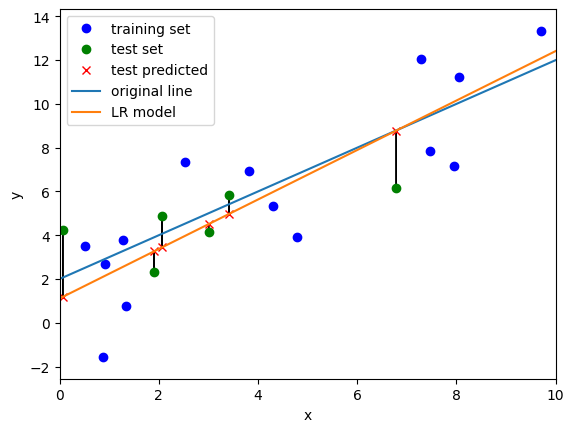

In [9]:
# --- predict the test data
y_pred_lr = lr_model_fit.predict (X_test.reshape(-1, 1))

print (" x         y         y pred.")
print ("--------  --------  --------")
for ind in range (X_test.size):
    print (f"{X_test [ind]:8.5f}  {y_test [ind]:8.5f}  {y_pred_lr [ind]:8.5f}")

mse_test = mean_square_error (y_test, y_pred_lr)
print (f"mse: {mse_test:7.4f}")

# --- plot the training and test data
plt.plot (X_train, y_train, 'bo', label = "training set")
plt.plot (X_test, y_test, 'go', label = "test set")
plt.plot (X_test, y_pred_lr, 'rx', label = "test predicted")

plt.xlim (x_min, x_max)
plt.xlabel ("x")

y_min = np.min ([np.min (y_data), np.min (y_pred_lr)]) - 1.0
y_max = np.max ([np.max (y_data), np.max (y_pred_lr)]) + 1.0
plt.ylim (y_min, y_max)
plt.ylabel ("y")

for ind in range (X_test.size):
    plt.arrow (X_test [ind], y_test [ind], 0.0, (y_pred_lr [ind] - y_test [ind]))
    
x_line = np.linspace (x_min, x_max, 100)
plt.plot (x_line, linear_model (x_line, slope, intercept), label = "original line")
plt.plot (x_line, linear_model (x_line, slope_fit, intercept_fit), label = "LR model")
plt.legend ()
plt.show ()

### 5 Bewerten und analysieren
Als Fehler kann jetzt, wie oben schon durchgeführt, die mitllere quadratische Abweichung (*mean squared error*, MSE) für die Testdaten berechnet werden.
Da hier nur ein Wert ermittelt ist, kann kein Vergleich mit anderen Ergebnissen, eventuell mit anderen Algorithmen durchgeführt werden.

Später wird die Analyse der Daten genauer erfolgen.

In [10]:
# --- calculate mse
mse_test = mean_square_error (y_test, y_pred_lr)
print (f"mse: {mse_test:7.4f}")

mse:  3.3252


## 6 Parameter verändern
Es wurde hier ein Durchlauf mit einem Algorithmus für das Maschinelle Lernen durchgeführt. Es gibt einige Dinge, die verändert werden können:
- die Aufteilung der Daten in Trainingsdtaen und Testdaten kann verändert werden,
- es kann ein anderer Algorithmus gewählt werden,
- die Bewertung kann verändert werden (wobei dies nichts daran ändert, dass hier nur ein Durchlauf durchgeführt wird)
- die Anzahl der Parammeter kann geändert werden.

Das ist nur ein kurzer Ausschnitt von Dingen, die verändert werden können.
Die vielfältigen Änderungsmöglichkeiten bedeuten, ein hoher Anfang am Anfang, um das Model geeignet zu definieren.

In den nachfolgenden Beispielen wird der Umfang der Trainingsdaten verändert.
Welche Veränderungen der gefundenen Lösung ergeben sich daraus?


number of learning data : 20
number of test data     : 6
  line : y =  0.9664 * x +  2.0994
  corr.coeff:  0.7537,  mse:  3.0062


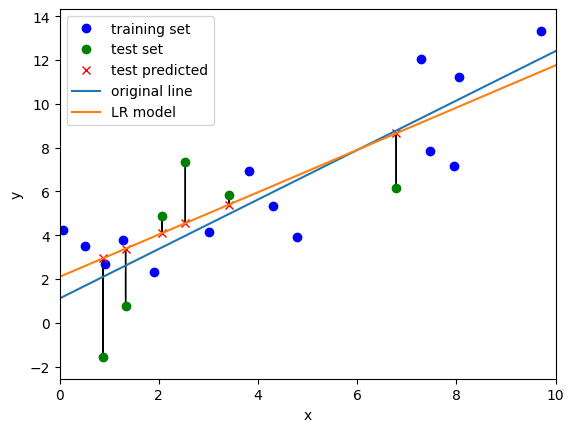

In [11]:
def LR (x_data, y_data, test_size, with_protocol = False, with_plot = False):
    X_train, X_test, y_train, y_test = train_test_split (x_data, y_data, test_size = test_size)
    lr_model = LinearRegression ()
    lr_model_fit = lr_model.fit (X_train.reshape(-1, 1), y_train)
    y_pred_lr = lr_model_fit.predict (X_test.reshape(-1, 1))

    slope = lr_model.coef_ [0]
    intercept = lr_model.intercept_
    corr_coeff = lr_model.score (X_train.reshape(-1, 1), y_train) # R^2 !!!
    mse = np.sum ((y_test - y_pred_lr) **2) / y_train.size

    if with_protocol:
        print ()
        print (f"number of learning data : {x_data.size:d}")
        print (f"number of test data     : {X_test.size:d}")
        print (f"  line : y = {slope:7.4f} * x + {intercept:7.4f}")
        print (f"  corr.coeff: {corr_coeff:7.4f},  mse: {mse:7.4f}")

        if with_plot:
            plt.plot (X_train, y_train, 'bo', label = "training set")
            plt.plot (X_test, y_test, 'go', label = "test set")
            plt.plot (X_test, y_pred_lr, 'rx', label = "test predicted")

            plt.xlim (x_min, x_max)
            plt.xlabel ("x")

            y_min = np.min ([np.min (y_data), np.min (y_pred_lr)]) - 1.0
            y_max = np.max ([np.max (y_data), np.max (y_pred_lr)]) + 1.0
            plt.ylim (y_min, y_max)
            plt.ylabel ("y")

            for ind in range (X_test.size):
                plt.arrow (X_test [ind], y_test [ind], 0.0, (y_pred_lr [ind] - y_test [ind]))
    
            x_line = np.linspace (x_min, x_max, 100)
            plt.plot (x_line, linear_model (x_line, slope_fit, intercept_fit), label = "original line")
            plt.plot (x_line, linear_model (x_line, slope, intercept), label = "LR model")
            plt.legend ()
            plt.show ()

    return slope, intercept, corr_coeff, mse

LR (x_data, y_data, 0.3, with_protocol = True, with_plot = True); # suppress output


In [12]:
LR (x_data, y_data, 0.1, with_protocol = True)
LR (x_data, y_data, 0.2, with_protocol = True)
LR (x_data, y_data, 0.3, with_protocol = True)
LR (x_data, y_data, 0.4, with_protocol = True);


number of learning data : 20
number of test data     : 2
  line : y =  1.0763 * x +  1.3911
  corr.coeff:  0.6837,  mse:  0.2758

number of learning data : 20
number of test data     : 4
  line : y =  1.0791 * x +  1.0774
  corr.coeff:  0.7278,  mse:  1.0646

number of learning data : 20
number of test data     : 6
  line : y =  1.0942 * x +  1.1669
  corr.coeff:  0.7711,  mse:  2.3631

number of learning data : 20
number of test data     : 8
  line : y =  1.2203 * x +  0.4545
  corr.coeff:  0.8142,  mse:  4.9139


Es ist zu erkennen, dass hier die Ergebnisse schlechter werden, je geringer der Datenumfang der Trainingsdtaen ist.

### 7 Maschinellen Lernen oder Modell fitten

Es stellt sich nun die Frage, was besser ist geeignet ist: die Analyse der Daten mit Hilfe von Methoden des Maschinellen Lernens
oder aber as direkte fitten des Modells.
Dazu schreibt Viviana Acquaviva [Acp23, siehe auch Acq19] über Vor- und Nachteile der beiden
Verfahren

#### Maschinelles lernen
- datengetrieben, daher nur so gut wie die Daten
- Verallgemeinerung nur schwer möglich (das angewandte Modell kann nicht blindlings auf andere Daten angewendet werden)
- Interpretation ist möglich, aber nicht einfach
- schnell
- robust gegenüber fehlenden Daten
- ermöglicht glückliche Entdeckungen

#### Modell direkt fitten
- getrieben durch Intuition oder Modell (nur so gut wie der Wissenschaftler)
- Verallgemeinerung (Anwendung auf weitere Daten) gut möglich, wenn die Physik gut verstanden ist
- Einfacher zu interpretieren
- rechenintensiv
- Umgang mit heterogenen Daten oftmals schwierig
- Führt zu Informationsverlust, wenn das Modell zu einfach ist

## Literatur
- [Acq2019] Viviana Acquaviva; Pushing the technical frontier: From overwhelmingly large data sets to machine learning; in Proceedings of the International Astronimical Union 15 ( S341), 88 - 98, https://doi.org/10.1017/S1743921319003077
- [Acq2023] Viviana Acquaviva; Machine Learning for Physisics and Astronomy; Princeton University Press; 2023
- [Erd2020] MArtin Erdmann, Thomas Hebbeker, Alexander Schmidt; Statistishce Methoden in der Experimentalphysik; Pearson: 2020